#  Urgency Level Classifier (Binary)
This notebook trains a classifier to predict whether a ticket is **High** urgency or **Not High**

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sentence_transformers import SentenceTransformer
import xgboost as xgb

c:\Users\yasha\Desktop\New folder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Cleaning

In [3]:
#  Load Data
df = pd.read_csv("ai_dev_assignment_tickets_complex_1000.csv")

# Drop duplicates and nulls
df = df.drop_duplicates(subset='ticket_text')
df = df.dropna(subset=['ticket_text', 'urgency_level'])

In [4]:
# Binary Label + Urgency Keyword Feature
df['urgency_binary'] = df['urgency_level'].apply(lambda x: 'High' if x == 'High' else 'Not High')

def urgency_score(text):
    keywords = ['urgent', 'asap', 'immediately', 'not working', 'waiting', 'help', 'escalated', 'delay', 'issue', 'problem']
    text = text.lower()
    return sum(kw in text for kw in keywords)

df['urgency_kw_score'] = df['ticket_text'].apply(urgency_score)

In [5]:
# Sentence Embeddings (SBERT)
model = SentenceTransformer('all-MiniLM-L6-v2')
X_embed = model.encode(df['ticket_text'].tolist(), show_progress_bar=True)

# Combine with urgency score
X = np.hstack([X_embed, df['urgency_kw_score'].values.reshape(-1, 1)])
y = df['urgency_binary'].map({'Not High': 0, 'High': 1})


Batches: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s]


In [6]:
#  Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [7]:
#  Train XGBoost Classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
clf.fit(X_train, y_train)

c:\Users\yasha\Desktop\New folder\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


              precision    recall  f1-score   support

           0       0.71      0.87      0.78        87
           1       0.61      0.35      0.45        48

    accuracy                           0.69       135
   macro avg       0.66      0.61      0.62       135
weighted avg       0.67      0.69      0.66       135



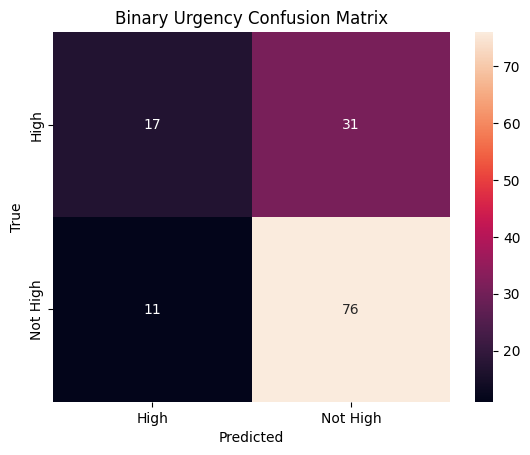

In [8]:
#  Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['High', 'Not High'], yticklabels=['High', 'Not High'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Binary Urgency Confusion Matrix")
plt.show()

In [9]:
# Save the model and vectorizer for future use
import joblib
joblib.dump(clf, './models/xgboost_urgency_classifier.pkl')
joblib.dump(model, './models/sbert_model.pkl')


['./models/sbert_model.pkl']